#  Demographic and Sentiment Analysis   
With the pandemic and its mitigation measures , nature seems to have taken back control of our world and many environmental parameters seem to have a positive impact. It invariably has affected the status quo and the business as usual of the world, with lot of questions raised on spending, office culture, poverty, sustainability, research grants, manufacturing, Technology etc. There has been a wide range of steps taken and mitigation put in place to address various issues from the National level up till the council level. It has now come to stage where we need tactical solutions and operational steps to get the economy moving, and the one level to implement is at a ward level. In this analysis 2 topics have been analysed using AI and Data science techniques to see what best way we can address the issue of economic revival. The topics are 
            1.  Demographics and Retail business.   
            2.  Sentiment Analysis using twitter data. 
            
Notes – 
1.	All packages required for this notebook are mentioned in the first cell. 
2.	There is one training file to be moved to the fastai folder, the same has been mentioned. 
3.	For sentiment analysis there two datasets one which is standard and other prepared for this analysis. 
4.	It takes around 30-40 mins for the models to run. I have kept the transform size to less than 64. 

                
### 1. Retail business and Demographic analysis

In this analysis we have identified various demographic attributes at a ward level and analysed whether there exists a pattern or correlation with the retail business in those wards. The London data store datasets are used for the retail sector analysis. Pydeck, skllearn and haven used in this analysis. the business in London data was obtained from the london data store, it had all registered business that fall in the active, inactive , dormant and various other states. It also had various type of business such as manufacturing, retail, hospitality, restaurants, wholesale etc. In this study we have confined our analysis to retail and active business. the other datasets that is been used is ward profile data from the London data store. This dataset provides a demographic break-up of the population in each of the wards. The latest demographic data available is from the year 2015. 

In [144]:
# !pip install tweepy
# !pip install json
# !pip install csv 
# !pip install pandas
# !pip install requests 
# !pip install geopandas 
# !pip install tweepy 
# !pip install datetime
# !pip install fastai 
# !pip install pydeck 
# !pip install workcloud

In [145]:
import json,urllib.request
import csv 
import pandas as pd
import requests
import geopandas as gpd
import geojson
import tweepy
import datetime
from fastai.text import *
import pydeck as pdk
from wordcloud import WordCloud, STOPWORDS 
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [146]:
%env MAPBOX_API_KEY=<mapbox key>

env: MAPBOX_API_KEY=pk.eyJ1IjoiYXJ1bmtvc2h5MTgiLCJhIjoiY2pxejNqMTl2MDdseTQ4cGNpdXN6OXE2ZiJ9.C9NoJtuiT9pDw5pyhYZxhQ


Data from various sources (London Data store & gov.uk) were downloaded and read using the pandas package. The row with null values and empty values were removed, and the dataframes were merged together using ward id (LSOA id) . the count of businesses at a ward level was aggregated and added as a column to the dataframe. A generic approach was then used to split X and y datasets. 

In [147]:
csv_file = 'businesses-in-london.csv'
csv_file1 = 'housing-density-ward.csv'
csv_file2 = 'ward-profiles-excel-2015_Updt.csv'
geojsonfile='londonwards.geojson'
df_dat = pd.read_csv(csv_file)
df_dat1 = pd.read_csv(csv_file1)
df_dat2 = pd.read_csv(csv_file2)
df_dat1 = df_dat1[df_dat1['Year']==2020]
df_dat2.head()


C:\Softwares\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Ward name,New code,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,% All Children aged 0-15 - 2015,% All Working-age (16-64) - 2015,% All Older people aged 65+ - 2015,Rate of JobSeekers Allowance (JSA) Claimants - 2015,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Unnamed: 13
0,City of London,E09000001,650,6250.0,1250.0,8.0,76.9,15.2,1.3,656.4,85.3,0.4,18.6,NaN
1,Barking and Dagenham - Abbey,E05000026,3850,10150.0,750.0,26.0,69.0,5.0,4.0,138.1,42.2,1.4,21.9,NaN
2,Barking and Dagenham - Alibon,E05000027,2700,6800.0,1050.0,25.7,64.3,10.0,3.7,73.6,27.3,0.7,20.6,NaN
3,Barking and Dagenham - Becontree,E05000028,3200,8350.0,1100.0,25.4,65.9,8.7,3.6,79.9,27.6,1.2,1.9,NaN
4,Barking and Dagenham - Chadwell Heath,E05000029,2550,6400.0,1450.0,24.3,61.5,14.2,3.7,76.1,24.6,1.3,56.0,NaN


In [148]:
df_data = df_dat[['CompanyName','CompanyNumber','CompanyStatus','IncorporationDate','SICCode.SicText_1',
                  'long','lat','lsoa11','ward']]
df_data.head()

,CompanyName,CompanyNumber,CompanyStatus,IncorporationDate,SICCode.SicText_1,long,lat,lsoa11,ward
0,!BIG IMPACT GRAPHICS LIMITED,11743365,Active,28/12/2018,18129 - Printing n.e.c.,-0.079703,51.527080,E01033706,E05009377
1,!L PRODUCTIONS LIMITED,12402527,Active,14/01/2020,90030 - Artistic creation,-0.024699,51.617737,E01004450,E05000607
2,!NKED LTD,12234705,Active,30/09/2019,47710 - Retail sale of clothing in specialised...,-0.106516,51.460017,E01003052,E05000420
3,!NVERTD DESIGNS LIMITED,09152972,Active,30/07/2014,58190 - Other publishing activities,-0.225428,51.503989,E01001941,E05000263
4,!YOZO FASS LIMITED,02714021,Active,12/05/1992,90010 - Performing arts,-0.032256,51.462230,E01003214,E05000439


In [149]:
df_data =df_data[df_data['SICCode.SicText_1'].str.contains('Retail') & df_data['CompanyStatus'].str.contains('Active')]
# df_data['SICCode.SicText_1'].value_counts()

Once these the merged and cleansed dataframe is ready. The analysis starts with trying to understand whether there is any strong correlation that exists among the variable. So a correlation matrix is generated on the merged dataframe. The correlation coefficient matrix show that there is no strong correlation that exists between the features and the no of business in the ward, the feature which had the highest correlation coefficient was crime rate which has a value of 0.67. Regression techniques was descoped from the analysis due to the week correlation.

In [150]:
df_dat3 = df_dat2[df_dat2.notnull()] 
df_data1 = df_data.merge(df_dat1,how='left',left_on = 'ward',right_on='Code' )
df_data2 = df_data1.merge(df_dat3, how='left',left_on = 'Code',right_on='New code')
df_data3 = df_data2[df_data2.notnull()]
df_data3 = df_data3[df_data3.notnull()]
df_data3 = df_data3.drop(['Unnamed: 13','Year'],axis=1)
df_data3.columns
df_dat.head()

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,oa11,laua,ward,lsoa11,msoa11,wz11,lat,long,calncv,stp
0,!BIG IMPACT GRAPHICS LIMITED,11743365,NaN,NaN,372 OLD STREET,335 ROSDEN HOUSE,LONDON,NaN,UNITED KINGDOM,EC1V9LT,...,E00176305,E09000012,E05009377,E01033706,E02000371,E33032136,51.527080,-0.079703,E57000002,E54000029
1,!L PRODUCTIONS LIMITED,12402527,NaN,NaN,95 MARMION AVENUE,NaN,CHINGFORD,NaN,ENGLAND,E48EJ,...,E00022386,E09000031,E05000607,E01004450,E02000900,E33036346,51.617737,-0.024699,E57000002,E54000029
2,!NKED LTD,12234705,NaN,NaN,29 CORRY DRIVE,NaN,LONDON,NaN,UNITED KINGDOM,SW98QS,...,E00015342,E09000022,E05000420,E01003052,E02000633,E33035130,51.460017,-0.106516,E56000010,E54000030
3,!NVERTD DESIGNS LIMITED,09152972,NaN,NaN,10 PENNARD ROAD,NaN,LONDON,NaN,ENGLAND,W128DS,...,E00009718,E09000013,E05000263,E01001941,E02000376,E33029826,51.503989,-0.225428,E57000003,E54000027
4,!YOZO FASS LIMITED,02714021,NaN,NaN,1 VERONICA HOUSE,WICKHAM ROAD,BROCKLEY,NaN,NaN,SE41NQ,...,E00016232,E09000023,E05000439,E01003214,E02000660,E33035248,51.462230,-0.032256,E56000010,E54000030


In [151]:
df_data4 = df_dat3

df_data4['Noofbusiness'] = 0
for i,r in df_data4.iterrows():
    count = df_dat[df_dat['ward'].isin([str(r['New code'])])]['CompanyNumber'].count()
    df_data4.at[i,'Noofbusiness'] = count

#### the whole analysis could be done with different Y variables. 
# y_value = 'WrkAgePop'
y_value = 'Retailbusiness'           # its mainly for readablity and any values could be used. 
y_col = 'Noofbusiness'               # please provide the column value that needs to be the dependent variable 
df_data4[y_value] = ""
mval = df_data4[y_col].median()      #Y value funciton used for classification it could be changed to a value, mean etc. 


for i,r in df_data4.iterrows():
    if(df_data4.at[i,y_col] >= mval ):
        df_data4.at[i,y_value] = "=>Mean"
    else:
        df_data4.at[i,y_value] = "<=Mean"
        
#     print(df_data4.iloc[i]['Noofbusiness'],count )

df_data4 = df_data4.drop(['Unnamed: 13'],axis=1)  
df_data4 = df_data4[df_data4['Noofbusiness'] > 0 ]
df_data4.head()

,Ward name,New code,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,% All Children aged 0-15 - 2015,% All Working-age (16-64) - 2015,% All Older people aged 65+ - 2015,Rate of JobSeekers Allowance (JSA) Claimants - 2015,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Noofbusiness,Retailbusiness
1,Barking and Dagenham - Abbey,E05000026,3850,10150.0,750.0,26.0,69.0,5.0,4.0,138.1,42.2,1.4,21.9,1921,=>Mean
2,Barking and Dagenham - Alibon,E05000027,2700,6800.0,1050.0,25.7,64.3,10.0,3.7,73.6,27.3,0.7,20.6,581,<=Mean
3,Barking and Dagenham - Becontree,E05000028,3200,8350.0,1100.0,25.4,65.9,8.7,3.6,79.9,27.6,1.2,1.9,969,=>Mean
4,Barking and Dagenham - Chadwell Heath,E05000029,2550,6400.0,1450.0,24.3,61.5,14.2,3.7,76.1,24.6,1.3,56.0,661,<=Mean
5,Barking and Dagenham - Eastbrook,E05000030,2150,7050.0,1550.0,20.1,65.7,14.2,4.0,66.7,24.5,0.8,50.4,713,<=Mean


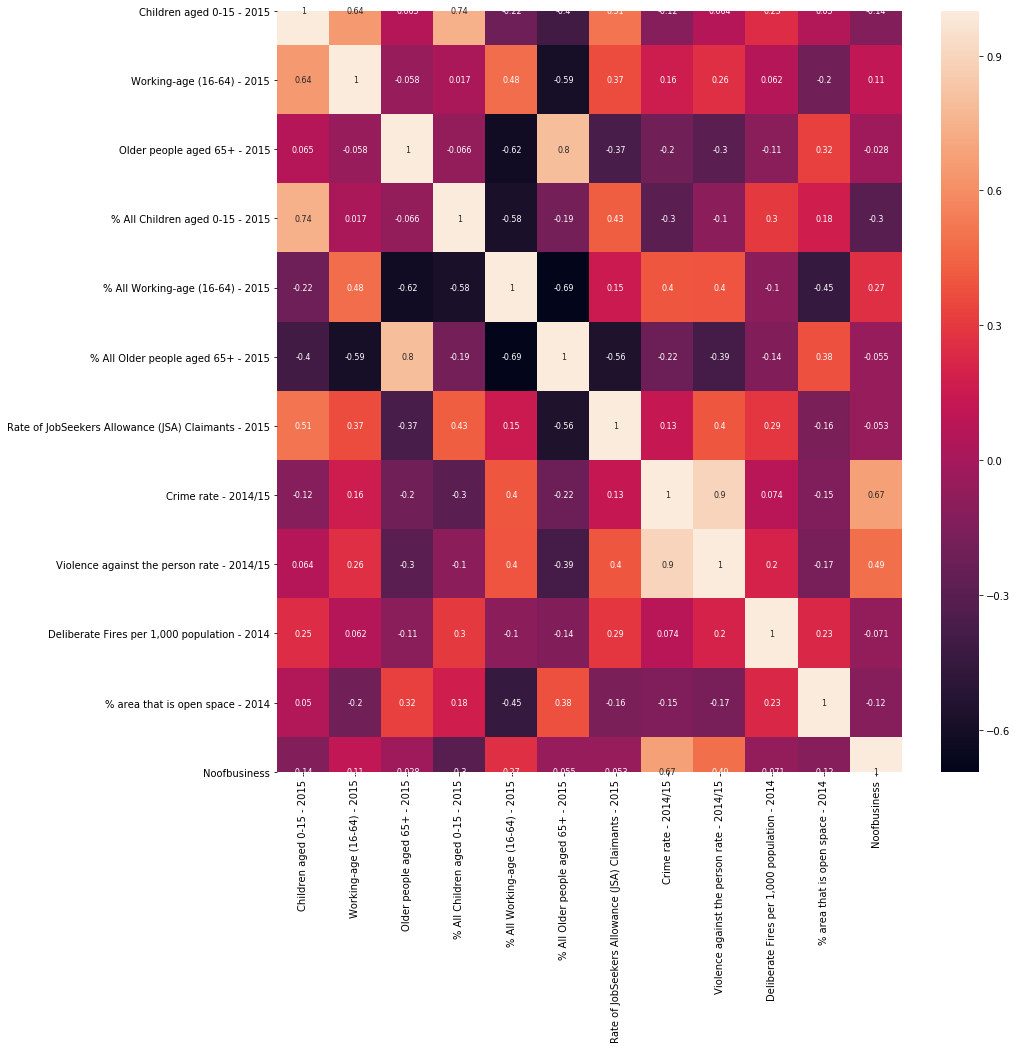

In [152]:
corrMatrix = df_data4.corr()
plt.figure(figsize = (14,14))
sn.heatmap(corrMatrix, annot=True, annot_kws={"size": 8})

 Clustering and classification techniques were then used to find patterns and other insights. KNN model is used for cluster analysis. The data set was split into training and test along with the corresponding labels. Scikit-learn package has been used for data preparation and analysis. The Y values split using the function (here we have used median) to classify the values as above median and below the median value. The label encoders from the scikit learn package to used to generate the labels required for training and testing data sets. Dictvectorizer is used to generate the vector object which is then used to carry out model fitting. The dictionary generated from this process is again split into test and training datasets. 
 

In [153]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
import time

df_data41 = df_data4.dropna()                 # df_data4.shape could be used
df_data41 = df_data41.drop(['Ward name','New code'], axis=1)
data = df_data41.drop(y_value, axis=1)
y = df_data41[y_value]
le = LabelEncoder()                           # crea'y_value'tes the LabelEncoder object
le.fit(['=>Mean','<=Mean'])                   # this gives you control on the order. 
labels_fea = le.transform(df_data41[y_value]) # runs LabelEncoder on the over50k column

train_d, test_d, train_lab, test_lab = train_test_split(df_data41, labels_fea)
data_dict = data.to_dict('record')
vec = DictVectorizer()                        # create the DictVectorizer object
data_mat = vec.fit_transform(data_dict)       # execute process on the record dictionaries
train_d
print(vec.vocabulary_)

{'Children aged 0-15 - 2015': 4, 'Working-age (16-64) - 2015': 11, 'Older people aged 65+ - 2015': 8, '% All Children aged 0-15 - 2015': 0, '% All Working-age (16-64) - 2015': 2, '% All Older people aged 65+ - 2015': 1, 'Rate of JobSeekers Allowance (JSA) Claimants - 2015': 9, 'Crime rate - 2014/15': 5, 'Violence against the person rate - 2014/15': 10, 'Deliberate Fires per 1,000 population - 2014': 6, '% area that is open space - 2014': 3, 'Noofbusiness': 7}


In [154]:
data_array = data_mat.toarray() 
train_d, test_d, train_lab, test_lab = train_test_split(data_array, labels_fea)

start_time = time.time()
clf_knn = KNeighborsClassifier(n_neighbors=60)  # creates the kNN classifier, setting it to check the 60 neighbouring points
clf_knn.fit(train_d, train_lab)                 # executes the classifier on the training dataset
end_time = time.time()
                                                
print(end_time - start_time)                    # print the time difference in seconds

0.024999618530273438


In [155]:
clf_knn.score(test_d, test_lab)

0.7416666666666667

A KNN classifier model is used with n as 60 (neighbours), this model is then trained using the vector datasets. The execution time from initialising to the model fitting run is 0.025 seconds and the accuracy of the model is 0.7417 which is a good value, the confusion matrix also shows the same. 


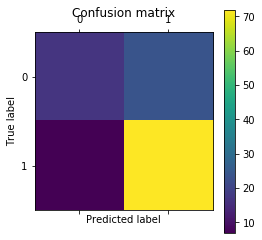

In [156]:
test_pred_knn = clf_knn.predict(test_d)

from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test_lab, test_pred_knn)

plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [157]:
print (metrics.classification_report(test_lab, test_pred_knn))

              precision    recall  f1-score   support

           0       0.71      0.41      0.52        41
           1       0.75      0.91      0.82        79

    accuracy                           0.74       120
   macro avg       0.73      0.66      0.67       120
weighted avg       0.74      0.74      0.72       120




The scikit learn is again used for cross validation and fine tuning the n value. The GridSearchCV package is used to fine tune the model for precision and recall, the n value are generated by the package. In this analysis, we have obtained a value of n=100 for precision and n=10 for recall. 


In [158]:
from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation

tuned_parameters = [{'n_neighbors': [10, 20, 50, 100, 200]}]


scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for :  %s" % score)
    print()

    clf = GridSearchCV(
        KNeighborsClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(train_d, train_lab)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

# Tuning hyper-parameters for :  precision



C:\Softwares\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Softwares\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Softwares\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Softwares\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Softwares\Anaconda\lib\site-packages\sklearn\

Best parameters set found on development set:

{'n_neighbors': 100}

Grid scores on development set:

0.803 (+/-0.098) for {'n_neighbors': 10}
0.814 (+/-0.102) for {'n_neighbors': 20}
0.774 (+/-0.098) for {'n_neighbors': 50}
0.856 (+/-0.011) for {'n_neighbors': 100}
0.344 (+/-0.001) for {'n_neighbors': 200}
# Tuning hyper-parameters for :  recall



C:\Softwares\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Softwares\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:

0.801 (+/-0.085) for {'n_neighbors': 10}
0.770 (+/-0.070) for {'n_neighbors': 20}
0.723 (+/-0.066) for {'n_neighbors': 50}
0.601 (+/-0.100) for {'n_neighbors': 100}
0.500 (+/-0.000) for {'n_neighbors': 200}


In [159]:
from sklearn.tree import DecisionTreeClassifier
clf_decision_tree = DecisionTreeClassifier()  # creates the kNN classifier, setting it to check the 60 neighbouring points
clf_decision_tree.fit(train_d, train_lab)

test_pred_decision_tree = clf_decision_tree.predict(test_d)
print (metrics.classification_report(test_lab, test_pred_decision_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        79

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120




Decision tree classification technique is used to check whether there exists a pattern in the features which could be broken into scenarios or rules. The decision tree is generated using the DecisionTreeClassifier package and the Gini value is 0.429. 


In [ ]:
# the code is based on this link: https://stackoverflow.com/a/59517013/4667568
decision_tree_depth_5 = DecisionTreeClassifier(max_depth=5)
decision_tree_depth_5.fit(train_d, train_lab)

plt.figure(figsize=(40,20))  # customize according to the size of your tree. If you can't see the tree clearly, you may change the size

from sklearn import tree
start_time = time.time()

# vec.feature_names_ represents the variable names
_ = tree.plot_tree(decision_tree_depth_5, feature_names = vec.feature_names_)
# if you want to save the picture to a file, add this line before plt.show()
plt.savefig('decision_tree.png')

plt.show()

end_time = time.time()
print(end_time - start_time)

In [161]:
from sklearn.tree import export_text
tree_rules = export_text(decision_tree_depth_5, feature_names=vec.feature_names_)
print(tree_rules)

|--- Noofbusiness <= 866.00
|   |--- class: 0
|--- Noofbusiness >  866.00
|   |--- class: 1



In [162]:
gjson = gpd.read_file(geojsonfile)
gjson[gjson['GSS_CODE'].isin(df_data1['Code'])]
gjson = gjson.merge(df_data1,how='left',left_on='GSS_CODE',right_on='Code')



The below visualisation shows the each business as a point on the map and the extrusion hight is the number of points or in this cases the no of business or retail outlets. A geojson layer with the population density has been added to the visualisation (it needs further work as geodataframe is not getting integrated to by pydeck api) 


In [163]:

view_state = pdk.ViewState(
    longitude=-0.12721,
    latitude=51.50642,
    zoom=9,
    min_zoom=6,
    max_zoom=14,
    pitch=60,
    bearing=-37.36)


hxlayer = pdk.Layer(
    'HexagonLayer',
     df_data2,
     get_position=['long', 'lat'],
     radius = 40,
     auto_highlight=True,
     elevation_scale=50,
     pickable=True,
     elevation_range=[0, 800],
     extruded=True,
     coverage=1
)

gelayer = pdk.Layer(
    'GeoJsonLayer',    
     gjson,
     opacity=0.8,
    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
    get_fill_color=[255, 255, 'population'*255],
    get_line_color=[255, 255, 255],
    pickable=True)

r = pdk.Deck(
             layers=[hxlayer,gelayer],
             initial_view_state=view_state)
r.to_html('hexagon-example.html')


'C:\\Users\\arunk\\OneDrive\\Documents\\DSSS_CASA0006\\FinalProject\\hexagon-example.html'

### 2. Sentiment Analysis on twitter data

Twitter data has been used for sentiment analysis along with fastai, CNN model and wordcloud packages. Tweets on the hashtag #covid19UK was used for training the model. twitter api keys were generated along with the authentication token. these keys and auth tokens are required for handshaking with the twitter server over the internet, this required by the twitter api's to fetch data. some of the trending hashtags in the UK were to used to retrieve data. 

In this Analysis we retrieve the tweets from a hashtag for the last 24 hrs. The tweets are stored in csv a file with columns datetime and tweet. we use two language models i.e. a learner model to read the text and classifier model to classify the text based on the sentiments as negative or positive. For visualisation purpose a the negative and positive tweets are segregated and a word cloud is generated. 

In [164]:
twitterKey1   = "WLqBJw0EvIQog3zYhaROOtCIK" 
twitterKey2   = "iBUMgSKfoYtOe1Oo404t4xFvtYcDBo63mGpwqad3lB4gQ6WdYM"
twitterToken1 = "3323360296-hIirCOQbMaDDsptkKBketUDCotEdDsDJ5QTc9jJ"
twitterToken2 = "3Bssu5DI57jeK1SZtPd30YcaLjMvg1Yz0QA20G5LsB31T"
# tweetHashtag  = "#Covid19UK"
tweetHashtag  = "#Clockdown"
tweetCsv      = 'covid19uktweets2.csv'
tweetcol1     = 'datetime'
tweetcol2     = 'tweet'
trainingCsv   = 'Training_covid19uktweets_labels.csv'
traincol      = 'tweet'
tweetno       = 250                            #due to time constraints we are restricting to these tweets.

The Twitter Api keys were generated by logging into twitter and creating the developer account. Then it allows to create the credentials, there is a limit to no of call’s that could be done using this credentials.  Tweepy package is used to for the api calls that made to twitter, it does the authentication using the credentials that are provided.

In [165]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(twitterKey1,twitterKey2)
auth.set_access_token(twitterToken1,twitterToken2)

api = tweepy.API(auth)
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [166]:
# prevdate = str(datetime.datetime.today() - datetime.timedelta(days=1)).split(".")[0]
# str(datetime.datetime.today() - datetime.timedelta(days=1))
prevdate = datetime.datetime.today() - datetime.timedelta(days=1)
prevdate

api = tweepy.API(auth,wait_on_rate_limit=True)
# Open/Create a file to append data
csvFile = open(tweetCsv, 'a')
#Use csv Writer
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search,q=tweetHashtag,count=100,
                           lang="en",
                           since=str(prevdate).split()[0]).items():
    if(tweet.created_at >= prevdate):
        csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])
#         print (tweet.created_at, tweet.text)        

In [167]:
# special characters to be removed  \\xe2, \\x80, \\x93, \\xa6, "\\", "@?", "RT", "b'" 
# rwords = ["\\xe2", "\\80", "\\x99","\\x93","\\xa6","xf0","x9f","x92","x95","x9c",tweetHashtag ] 

pd_csv = pd.read_csv(tweetCsv,header=None)
pd_csv[0] = pd.to_datetime(pd_csv[0])
pd_csv[1] = pd_csv[1].astype('str')
pd_csv.columns = [tweetcol1,tweetcol2]
pd_csv.head()

,datetime,tweet
0,2020-05-07 12:03:32,b'RT @KMJ_1802: The series that truly began th...
1,2020-05-07 12:02:08,b'RT @Andydrewz: The Girl in the Fireplace (19...
2,2020-05-07 12:01:19,b'RT @StevenWMoffat: People have always asked ...
3,2020-05-07 11:53:59,b'RT @BadWolfArchives: I think I speak for all...
4,2020-05-07 11:50:48,b'RT @TrilbeeReviews: I think fans have been s...


I have used both a IMDB dataset and self labelled data set for this analysis. The IMDB datasets comes standard with fastai and it comes with labels for sentiment analysis. In the first part the training dataset is used to fit the language model learner model the cycle was two epoch with 2 cycles each i.e. (2x2) . the encoder or model thus generated is stored to persistent drive as a file. The fitting process provides the training losses, validation loss, accuracy and time used. With the IMDB data set it requires are 30-40 mins, however my dataset being small could do it in a few minutes but of course at lower accuracy and higher loss. 

In [168]:
defaults.cpus=1 # Reason: https://github.com/fastai/fastai/issues/1850
imdb = untar_data(URLs.IMDB_SAMPLE)
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
# data_lm = (TextList.from_csv(imdb, trainingCsv, cols=traincol)
                   .split_by_rand_pct()
                   .label_for_lm()
                   .databunch(num_workers=0))
data_lm.save()
data_lm.show_batch()

idx,text
0,"! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk ! xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is"
1,"nice , creepy xxmaj spanish castle and good xxunk , i found it to be fairly boring and predictable , with no excitement or mystery , whatsoever . \n \n 3 out of 10 . xxbos a really great movie and true story . xxmaj dan xxmaj jansen the xxmaj greatest xxunk ever . a touching and beautiful movie the whole family can enjoy . xxmaj the story of"
2,"go even 5 feet away from a croc . \n \n xxmaj but , everything in this movie is bad . xxmaj xxunk jokes , people getting xxunk , and the xxunk about the xxmaj president all make the movie one of the worst of all time . \n \n xxmaj it 's a really bad film that you have to stay away from . xxmaj all the"
3,"xxunk . xxmaj the acting talent is xxunk xxunk : xxmaj xxunk and xxmaj xxunk are good but do n't have to try very hard : xxmaj xxunk at least has a great voice and some feel for the material . xxmaj julia looks perfect as xxmaj xxunk , but struggles with the character , xxunk by a fake xxunk accent . xxmaj harris 's xxmaj xxunk is embarrassingly mannered"
4,"changed the labor camp at xxmaj xxunk to a ship full of xxunk slaves . xxmaj the scene at xxmaj bishop xxmaj xxunk 's was fine . xxmaj in fact , other than the xxunk , things survived up until the xxunk of xxmaj fantine . xxmaj because we do not want to have bad things happen to a good woman , she does not cut her hair , sell"


Pls note – the ‘Training_covid19uktweets_labels.csv’ file needs to be copied to the 	‘C:\Users\Windows user\\.fastai\data\imdb_sample\’     folder.

The show results function shows the text , target and predicted values. it shows the results in chunks of 20’s words. 

In [169]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.fit_one_cycle(2, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')
learn.show_results()

epoch,train_loss,valid_loss,accuracy,time
0,4.303894,3.780577,0.289926,23:08
1,4.017747,3.755334,0.291964,23:02


text,target,pred
"xxbos xxmaj how does an usual day start in xxmaj point xxmaj place , xxmaj xxunk ... \n \n","xxmaj first of all , xxmaj red , the xxunk father of the xxmaj xxunk family and a xxup wwii",", all , xxmaj xxunk xxmaj xxmaj xxunk , , the xxunk xxunk , , the xxunk xxunk xxunk ,"
return they come back as xxunk . xxmaj in desperation the king xxunk the xxunk xxunk to stop the world,xxunk . xxmaj xxunk of course xxunk along ... \n \n xxmaj what can i say other then why,"from . xxmaj the is the , the with xxmaj xxmaj the 's you say about than ? ? the"
"killing the heroine off , this is just xxunk junk . \n \n xxmaj both xxunk and college students","get a bad xxunk here . xxmaj they are xxunk as xxunk , xxunk xxunk who have way too many","xxunk movie . . xxmaj the are xxunk by they , and , , are been to much xxunk problems"
"that gets turned out as cinema , as xxmaj indians we can xxunk xxunk that we have the biggest cinema","industry , however it also the worst . \n \n how can other poor countries have films with real","in in and , 's has xxunk movie xxmaj xxmaj much you people people do a like a xxunk ?"
"100 , having proved that he was more than just a brilliant straight man for his wife xxmaj gracie xxmaj",xxunk . xxbos ... and how they bore you right out of your mind ! xxmaj the xxmaj crater xxmaj,"allen , xxmaj xxmaj xxmaj the the did the . . of the xxunk . xxmaj the xxunk xxunk xxmaj"


#### Build the classifer for sentiment analysis

With the model being ready, we can proceed to build the classifier. Again there are two data sets IMDB and one created by me to train the model. So the dataclass object will read from the csv file which has labels defined for the text and a which has field to mention whether the text is a valid one that could be used for training. The dataobject also takes various other parameters such as number of workers and batchsize, which will be handy when doing performance tuning. Once the data object is created from the file, a ‘show_batch()’ call will show the data. 

In [170]:
data_clas = (TextList.from_csv(imdb, 'Training_covid19uktweets_labels.csv', cols='tweet', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42,num_workers=0))
data_clas.show_batch()

text,target
xxbos xxunk from xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk : forget xxunk and xxunk xxunk xxunk xxunk xxunk xxunk xxunk what we want is proper pay and xxup xxunk # xxup xxunk # xxunk # xxup xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk : / / xxunk / xxunk ',negative
xxbos xxunk reason why they do nt take the xxmaj xxunk cure serious xxrep 5 . is xxunk its the cure is xxunk not scientific xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk : / / xxunk / xxunk ',positive
xxbos xxunk xxunk : xxmaj the reason why they do nt take the xxmaj xxunk cure serious xxrep 5 . is xxunk its the cure is xxunk not scientific xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk # xxunk xxunk xxunk xxunk xxunk xxunk xxunk ',positive
"xxbos xxunk xxunk : xxmaj this week xxunk xxunk xxunk xxunk xxunk xxunk 3rd most read on xxunk : xxmaj after the # xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk workers can xxunk xxunk xxunk xxunk xxunk xxunk t pay the price again says xxmaj xxunk 's xxunk xxunk xxunk xxunk xxunk xxunk """,negative
"xxbos xxunk it be xxmaj xxunk in xxmaj xxunk , xxmaj xxunk in xxmaj xxunk , xxup nyc - xxmaj florida in xxmaj october , or xxmaj xxunk xxunk xxunk xxunk xxunk in xxmaj xxunk ? ... ( first post lock xxunk xxunk xxunk xxunk xxunk xxunk xxunk : / / xxunk / xxunk '",negative


The data object could be used to train the text classifier. The model that we are using here is AWD_LSTM.  The fastai learn object is used run this model, the saved encoder from the previous model is used. The learn model is fitted on the dataset that we created in the previous step. We run the model for 2 epoch’s and different slices of data. The trained is model is saved for further use, the training results are shown below. We have a very low accuracy that is shown which is partly because of using my labelled dataset. 

In [171]:
learn = text_classifier_learner(data_clas, AWD_LSTM)
learn.load_encoder('mini_train_encoder')
learn.fit_one_cycle(2, slice(1e-3,1e-2))
learn.save('mini_train_clas')
learn.show_results()

epoch,train_loss,valid_loss,accuracy,time
0,0.678845,0.702302,0.307692,00:14
1,0.643173,0.724403,0.269231,00:13


text,target,prediction
xxbos xxunk xxunk / xxunk / xxunk . xxunk xxunk moving mean new values xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk . xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk new cases with date occurred xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk : / / xxunk / xxunk ',negative,positive
xxbos xxunk / 5 / 20 xxunk # xxmaj xxunk deaths xxunk xxup uk xxunk xxunk xxup usa xxunk xxunk xxmaj germany xxunk xxunk xxmaj australia xxunk xxunk xxmaj deaths per million population xxunk xxup uk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk : / / xxunk / xxunk ',positive,negative
xxbos xxunk on your xxunk i know you xxunk xxunk xxunk xxunk xxunk xxunk told this on a daily basis but we won xxunk xxunk xxunk xxunk xxunk xxunk t stop until we get justice ! xxunk xxunk xxunk xxunk xxunk xxunk xxunk : / / xxunk / xxunk ',negative,positive
"xxbos xxunk xxunk : xxmaj my goodness . xxmaj another example we should follow instead of saying , face xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk be xxunk , as xxmaj johnson has stated . xxunk xxunk xxunk xxunk xxunk xxunk '",negative,positive
"xxbos xxunk xxunk xxunk xxmaj remember some else has to clear up thrown - away xxunk xxunk xxup plastic xxup xxunk , xxup xxunk xxup xxunk , xxup xxunk xxunk xxmaj what is xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk : / / xxunk / xxunk '",negative,positive


The tweets extracted earlier is read from the csv file into a dataframe, a for loop is used to iterate through the dataframe rows and each tweet is fetched. The tweets are then fed into the model and the predictions are obtained. The predictions are stored against each of the row of the tweet. Please note we have restricted the tweets to 250 (initialise in a variable) due to time and performance constraints. The predictions will tell whether the tweet holds a negative or positive sentiment. 

In [172]:
pd_tweet = pd.read_csv(tweetCsv,header=None)
pd_tweet.columns = [tweetcol1,tweetcol2]
pd_tweet['label'] =""
pd_tweet.iloc[1,1]

for i in range(0, tweetno):
    pred = learn.predict(pd_tweet.iloc[i,1])
    pd_tweet.iloc[i,2] = pred[0]
    
pd_tweet.head()

C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\

C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\

C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\

C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\

C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\

C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\

C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\

C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Softwares\Anaconda\lib\site-packages\

,datetime,tweet,label
0,2020-05-07 12:03:32,b'RT @KMJ_1802: The series that truly began th...,positive
1,2020-05-07 12:02:08,b'RT @Andydrewz: The Girl in the Fireplace (19...,positive
2,2020-05-07 12:01:19,b'RT @StevenWMoffat: People have always asked ...,positive
3,2020-05-07 11:53:59,b'RT @BadWolfArchives: I think I speak for all...,positive
4,2020-05-07 11:50:48,b'RT @TrilbeeReviews: I think fans have been s...,positive


The above dataframe is then used to read the positive and negative tweets separately. The tweets are concatenated together and send the wordcloud package to create the workcloud. The there are special characters that needs to be filter from tweets. Thus it gives two images with most used words in each of the case. This helps in understanding the talk of the city or country and how the narrative that goes out from govt and policy makers should acknowledge it. Mental health and well being is at these times is a matter of very grave concern. 

In [173]:
NegStr = ""
PosStr = ""

for i in range(0, tweetno):
    val= pd_tweet.iloc[i,2]
    if(str(val) == "positive"):
        PosStr= PosStr+" " + pd_tweet.iloc[i,1]
    else:
        NegStr= NegStr+ " " + pd_tweet.iloc[i,1]

stopwords = set(STOPWORDS) 
stopwords_i = ["https", "co", "RT","x80","xa6","xe2","xa6","b'","xe2", "\\80", "x99","x93","xa6",
               "xf0","x9f","x92","x95","x9c","x98","x82",'x9a','x8c',tweetHashtag ] 

def generate_wrdcloud(Text,Bkgdcolor):   
    if (len(Text)==0):
        print('Empty Text')
        return 0
    
    for sword in stopwords_i:
        Text = Text.replace(sword,"")
        
    wordcloud = WordCloud(width = 1480, height = 490, 
                    background_color =Bkgdcolor, 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(Text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None)  
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
#     plt.savefig('Prj1.png')
    plt.show() 

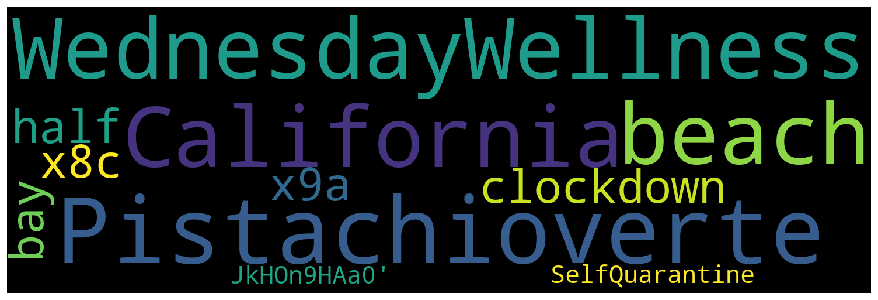

In [174]:
generate_wrdcloud(NegStr,"black")

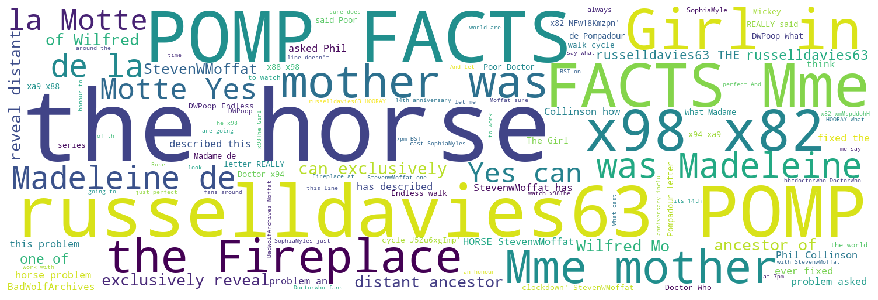

In [175]:
generate_wrdcloud(PosStr,"white")

### Conclusion 

In these uncertain time when Covid19 pandemic mitigation strategies taking adverse toll on the economy and well being of the public.  the two points analysed in the notebook could help us in coming up with bespoke solutions to address issues. 

The KNN clustering gives the best results in identifying patterns with a accuracy of 0.7417. This model could be enhanced further to try and learn where best to invest the efforts and resources so that retail can start over again with social distancing and other rules in place in the new normal. The demographic variables used in this analysis is of 2015 and latest data on these will prove pivotal. There are again environmental parameters which have not been considered for this study, which could aid in policy and decision making in the new normal. 

The sentiment analysis helps in understanding the talk of the city or country and how the narrative that goes out from govt and policy makers could acknowledge it. Mental health and well being is at these times is a matter of very grave concern and should be looked into with great importance as it has very adverse effects on various other factors such as productivity, performance, growth etc. 

Multiobject detection using the cctv camera could be used to efficiently do crowd management and help people with social distancing and etiquettes required to sustain in the new normal until a medical breakthrough is achieved.

News feeds could be integrated with twitter analysis to understand the narratives which has had the worst and best impact on peoples sentiments. This could also be used to understand the audience well and channel resources better. 

Geofencing and spatiotemporal data could be used in the future if there is a subsequent wave of the pandemic. Location intelligence will prove a pivotal role is containing and mitigating actions to fight a pandemic like this. The new normal will also need to address issues like environment and health etc and spatial analysis will play major part in policy making and planning. 
